#LSTM Music Notes Generation

##Imports

In [ ]:
!pip install pretty_midi

In [3]:
import pathlib
import pretty_midi
import glob
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import mido

##Prepare the data

In [4]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 2s 0us/step


In [108]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of songs:', len(filenames))


Number of songs: 1282
data/maestro-v2.0.0/2017/MIDI-Unprocessed_054_PIANO054_MID--AUDIO-split_07-07-17_Piano-e_1-02_wav--2.midi


In [10]:
# cut the song in semi-redundant sequences of maxlen notes
maxlen = 40
step = 3
n_song = 10

In [12]:
songs = [pretty_midi.PrettyMIDI(file) for file in filenames[:n_song]]
print(len(songs))

10


In [8]:
def pitch_to_array(pitch):
    array = np.zeros((128, 1))
    array[pitch] = 1
    return array

In [13]:
def song_to_data(start, notes):
    x = np.zeros((maxlen, 128))
    y = np.zeros((1, 128))
    for i in range(start, start+maxlen):
        x[i-start,notes[i]] = 1
    y[0, notes[start+maxlen]] = 1
    return (x, y)

In [15]:
x_train = np.zeros((0, maxlen, 128))
y_train = np.zeros((0, 1, 128))

for i, song in enumerate(songs[:n_song]):
    inst = song.instruments[0]
    notes = [note.pitch for i, note in enumerate(inst.notes)]
    start = 0
    print("[Loading]... Song number : " , i ," - Number of notes : " ,len(notes))
    while start+maxlen < len(notes):
        x, y = song_to_data(start, notes)
        x_train = np.append(x_train, x.reshape((1, maxlen, 128)), axis=0)
        y_train = np.append(y_train, y.reshape((1, 1, 128)), axis=0)
        start += step

[Loading]... Song number :  0  - Number of notes :  5949
[Loading]... Song number :  1  - Number of notes :  1638
[Loading]... Song number :  2  - Number of notes :  3321
[Loading]... Song number :  3  - Number of notes :  6943
[Loading]... Song number :  4  - Number of notes :  7348
[Loading]... Song number :  5  - Number of notes :  3326
[Loading]... Song number :  6  - Number of notes :  3175
[Loading]... Song number :  7  - Number of notes :  1618
[Loading]... Song number :  8  - Number of notes :  2831
[Loading]... Song number :  9  - Number of notes :  2232


In [19]:
np.save('data/x_train.npy', x_train)
np.save('data/y_train.npy', y_train)

In [23]:
print(x_train.shape)
y_train = y_train.reshape((12663,128))
print(y_train.shape)

(12663, 40, 128)
(12663, 128)


##Build the model

In [24]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, 128)),
        layers.LSTM(128),
        layers.Dense(128, activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
Total params: 148,096
Trainable params: 148,096
Non-trainable params: 0
_________________________________________________________________


In [26]:
epochs = 40
batch_size = 128

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/40
99/99 [==============================] - 13s 110ms/step - loss: 4.0643
Epoch 2/40
99/99 [==============================] - 11s 115ms/step - loss: 3.6756
Epoch 3/40
99/99 [==============================] - 10s 100ms/step - loss: 3.4612
Epoch 4/40
99/99 [==============================] - 10s 99ms/step - loss: 3.2717
Epoch 5/40
99/99 [==============================] - 10s 101ms/step - loss: 3.0793
Epoch 6/40
99/99 [==============================] - 10s 101ms/step - loss: 2.8613
Epoch 7/40
99/99 [==============================] - 10s 99ms/step - loss: 2.6306
Epoch 8/40
99/99 [==============================] - 10s 99ms/step - loss: 2.3976
Epoch 9/40
99/99 [==============================] - 10s 99ms/step - loss: 2.1738
Epoch 10/40
99/99 [==============================] - 10s 99ms/step - loss: 1.9580
Epoch 11/40
99/99 [==============================] - 10s 100ms/step - loss: 1.7534
Epoch 12/40
99/99 [==============================] - 10s 98ms/step - loss: 1.5755
Epoch 13/40
99/99 [

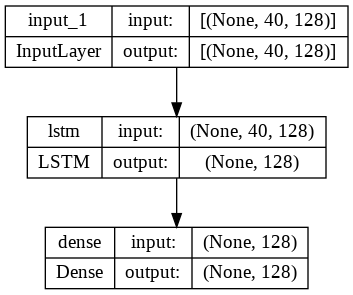

In [27]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

dict_keys(['loss'])


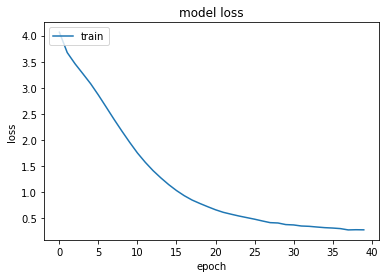

In [34]:
import matplotlib.pyplot as plt

history = model.history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [54]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [55]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import fluidsynth

In [60]:
def pitch_to_midi(pitch_sequence):
    tempo = mido.bpm2tempo(120)
    time_signature = (4, 4, 24, 8)

    # Create a MIDI file and add the tempo and time signature information
    mid = mido.MidiFile()
    mid.ticks_per_beat = 480
    mid.tracks.append(mido.MidiTrack())
    mid.tracks[0].append(mido.MetaMessage("set_tempo", tempo=tempo))
    mid.tracks[0].append(mido.MetaMessage("time_signature", numerator=time_signature[0], denominator=time_signature[1], clocks_per_click=time_signature[2], notated_32nd_notes_per_beat=time_signature[3]))

    # Convert the pitch sequence to a list of MIDI notes
    notes = []
    for pitch in pitch_sequence:
        notes.append(mido.Message("note_on", note=pitch, velocity=100, time=0))
        notes.append(mido.Message("note_off", note=pitch, velocity=100, time=480))

    # Add the notes to the MIDI file
    mid.tracks[0].extend(notes)

    # Save the MIDI file
    mid.save("pitch_sequence.mid")

In [117]:
print(filenames[0])
pred_song = pretty_midi.PrettyMIDI(filenames[20])
inst = pred_song.instruments[0]

pred_notes = [notes.pitch for i, notes in enumerate(inst.notes)]
pitch_to_midi(pred_notes)
x, y = song_to_data(0, pred_notes)
x = x.reshape((1, 40, 128))
print(x.shape)

print(pred_notes[:10])

data/maestro-v2.0.0/2017/MIDI-Unprocessed_048_PIANO048_MID--AUDIO-split_07-06-17_Piano-e_2-05_wav--4.midi
(1, 40, 128)
[39, 27, 51, 42, 51, 30, 33, 39, 45, 51]


In [118]:
total_song = pred_notes[:40]


for j in range(100):
  preds = model.predict(x)
  print(np.argmax(preds))
  total_song.append(np.argmax(preds))
  preds[0,np.argmax(preds)] = 1
  preds[preds != 1] = 0
  for i in range(maxlen-1):
    x[0, i, :] = x[0, i+1, :]
  x[0, maxlen-1, :] = preds[0]


print(total_song)

print(pred_notes[:140])

1/1 [==============================] - 0s 26ms/step
66
1/1 [==============================] - 0s 74ms/step
67
1/1 [==============================] - 0s 95ms/step
51
1/1 [==============================] - 0s 76ms/step
50
1/1 [==============================] - 0s 30ms/step
78
1/1 [==============================] - 0s 18ms/step
71
1/1 [==============================] - 0s 27ms/step
43
1/1 [==============================] - 0s 18ms/step
39
1/1 [==============================] - 0s 31ms/step
46
1/1 [==============================] - 0s 17ms/step
76
1/1 [==============================] - 0s 20ms/step
43
1/1 [==============================] - 0s 17ms/step
53
1/1 [==============================] - 0s 18ms/step
55
1/1 [==============================] - 0s 19ms/step
53
1/1 [==============================] - 0s 26ms/step
59
1/1 [==============================] - 0s 21ms/step
68
1/1 [==============================] - 0s 19ms/step
46
1/1 [==============================] - 0s 19ms/step
53
1/1 [=====